# <font color=purple>Use Cases - Age and Location (Geospatial Analysis)</font>

## <font color=purple>1. Background</font>

Below are some research questions in demonstrating different use cases.

1. What are the trends of people's occupations over the years between 1980's to 2020's?
2. Are there more older people who work in professional roles?
3. **<font color=blue>What is the age of people who is born outside of mainland China?</font>**
4. **<font color=blue>Are there more younger people who was born Hong Kong than in mainland China?</font>**
5. What are the differences in occupations between older people who were born in Taiwan and mainland China?
6. Are there more younger people who have a university degree and who was born in Hong Kong?
7. Does people who work in professional roles will have less children?

In order to address these questions, you'll need to install and connect to a graph database instance to pull out the data to perform the analysis using machine learning and other AI approaches. Variables are based on the  volcabulary. Below are some of the variables of interest for the above research questions:

- _Reference Date of Dataset_
- _Date of Birth (derive Age)_
- _Place of Birth_
- _Occupation_
- _Credential_
- _Children_

This tutorial will perform a multivariate analysis, time series, etc. to address the second research question on age and location. A summary of each analysis will be used to describe the relevant analysis.

## 1.1 Installing Python and AllegroGraph

The script requires setting up the Python 3 environment. You should setup a virtual machine to ensure all Python 3 dependencies are installed and self-contained. The script also requires setting up AllegroGraph into the Python environment. [AllegraGraph](https://allegrograph.com/products/allegrograph/) is a document-centric graph database that allows researchers and AI practitioners the ability to perform SPARQL queries on heterogeneous data using _Resource Description Framework (RDF)_. More information about the development environment can be found [here](http://#).
 
## 1.2 Ingesting Data into Graph Database Instance (Local/Remote)

After setting up Python and AllegroGraph environment, you'll need to import data into the graph database (AllegroGraph) instance whether this is running on your local machine or in the cloud. You can pull the necessary resources from the project's Github. A folder called `/ingestion` contains all of the JSON-LD data files. The JSON-LD files contains the relevant RDF encodings including the links to the relevant ontologies. Our system builds on the [Schema.org](https://schema.org) volcabulary. More information about the respository and graph data platform can be found [here](http://#).

## <font color=purple>2. Import Libraries</font>

To begin, you'll need to import python libraries in order to be able to connect to the graph database to extract data, perform queries, perform any transformation, and to plot and analyse the data. 

In [2]:
# file processing and database
from franz.openrdf.connect import ag_connect
from franz.openrdf.query.query import QueryLanguage
import json
import csv
import os
import pandas as pd
import numpy as np
import math
from datetime import datetime

# NLP
from nlp_utils import *                             # NLP utilities
import re                                           # regex
import nltk                                         # natural language toolkit

# ML
from sklearn import metrics                         # scikit learn ML framework
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

# Statistical Learning
from scipy import spatial
import statsmodels.api as sm                        # statsmodels framework
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.discrete.conditional_models import ConditionalMNLogit

# Visual
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from statsmodels.graphics.factorplots import interaction_plot
import seaborn as sns
from IPython.display import display, HTML
from PIL import Image


## <font color=purple>3. SPARQL Query for Research Questions

In order to develop the dataset(s) to address each of the research question relating to age and occupation, you need to develop several SPARQL queries. [SPARQL](https://www.w3.org/TR/rdf-sparql-query/) is a query language used for retrieving RDF data.  Analysis will depend on an aspect of the research question and will adopt the appropriate method such as multivariate analysis or timeseries analysis. A full list of SPARQL queries for these notes can be found [here](https://#/).

## 3.1 SPARQL query for Research Question 2

In [2]:
query_string_2_1 = """
    PREFIX cwork: <http://schema.org/CreativeWork>

    SELECT ?_year ?_id 
    WHERE{
        ?subject a ?Dataset ;
            cwork:contentReferenceTime ?_year ;
            cwork:contributor ?_contributor .
        BIND(iri(strafter(?_contributor, ":")) As ?_id)
    }
"""

query_string_2_2 = """
    PREFIX per: <http://schema.org/Person>
    PREFIX occ: <http://schema.org/Occupation>

    SELECT DISTINCT ?_identifier ?_dob ?_occupation_name
    WHERE
    { 
        ?subject a ?Person ;
                 per:identifier ?_identifier ; 
                 per:hasOccupation ?_occupation .
        ?_occupation occ:name ?_occupation_name .
        OPTIONAL { ?subject per:birthDate ?_dob . }
    }    
"""

## <font color=purple>4. Connect to Graph Database</font>

Next you'll need to connect to the graph database instance. The current code uses a graph database instance hosted on the local machine. If the graph database instance is hosted in the cloud, then an endpoint will need to be created for consumption.

In [3]:
conn = ag_connect('surveydatacommons', host = 'localhost', 
                  port = '10035', user = 'test', 
                  password = 'xyzzy', create=True)

conn.openSession()

## <font color=purple>5. Retrieve Data for Analysis</font>

Evaluate the results of each query and retrieve dataset for analysis. Remember to the close connection session once finished. For question 2, there are three seperate queries, the results for each query will be analysed in one dataframe.

## 5.1 Data for Research Question 2

In [4]:
# display unaggregated data for question 2

tuple_query_2_1 = conn.prepareTupleQuery(QueryLanguage.SPARQL, query_string_2_1)
result_2_1 = tuple_query_2_1.evaluate()

tuple_query_2_2 = conn.prepareTupleQuery(QueryLanguage.SPARQL, query_string_2_2)
result_2_2 = tuple_query_2_2.evaluate()

df_2_1 = pd.DataFrame({"Year":[], "Contributor":[]})
df_2_2 = pd.DataFrame({"Person":[], "DOB":[], "Occupation":[]})

for binding_set_2_1 in result_2_1:
    y = str(binding_set_2_1.getValue("_year"))
    c = str(binding_set_2_1.getValue("_id"))
    contributor = c.split('#')[1].replace("\"", "").replace(">", "")
    data = pd.DataFrame({"Year":y, "Contributor":contributor}, index=[0])
    df_2_1 = pd.concat([data, df_2_1.loc[:]]).reset_index(drop = True)
result_2_1.close()

for binding_set_2_2 in result_2_2:
    p = str(binding_set_2_2.getValue("_identifier"))
    d = str(binding_set_2_2.getValue("_dob"))
    o = str(binding_set_2_2.getValue("_occupation_name"))
    person = p.replace("\"", "")
    data = pd.DataFrame({"Person":person, "DOB":d, "Occupation":o}, index=[0])
    df_2_2 = pd.concat([data, df_2_2.loc[:]]).reset_index(drop = True)
result_2_2.close()

display(df_2_1)
display(df_2_2)

,Year,Contributor
0,"""1997""",61834
1,"""1997""",90865
2,"""1997""",10241
3,"""1997""",90614
4,"""1997""",12810
...,...,...
141900,"""2019""",158071111
141901,"""2008""",324302
141902,"""2003""",12721
141903,"""1999""",50320


,Person,DOB,Occupation
0,60652,"""NA""","""Other Production and Related Workers"""
1,41619,"""NA""","""Servicemen Enlisted Men"""
2,70601,"""1924-10-01""","""Crane hoist and related plant oper"""
3,595,"""1953-06-01""","""Dont know"""
4,1127,"""1958-06-01""","""Non manual office worker non supervisor"""
...,...,...,...
75599,3335200708,"""1955-1-01""","""Agricultural and Animal Husbandry Workers"""
75600,3335200710,"""1951-12-01""","""Legislators and Government Administrators"""
75601,3335200712,"""1937-6-01""","""Agricultural and Animal Husbandry Workers"""
75602,3335200713,"""1927-9-01""","""Agricultural and Animal Husbandry Workers"""


In [5]:
# clean and prepare unaggregated data for question 2

df_2_1.rename(columns = {"Contributor": "Person"}, inplace = True)
df_2_2.rename(columns = {"Person": "Person"}, inplace = True)

df_2_3 = pd.merge(df_2_1, df_2_2, how = "outer", on = ["Person"])
df_2_3["Year"] = df_2_3["Year"].str.replace("\"", "")
df_2_3["DOB"] = df_2_3["DOB"].str.replace("\"", "")
df_2_3["Occupation"] = df_2_3["Occupation"].str.replace("\"", "")
df_2_3["Year"] = pd.to_numeric(df_2_3["Year"])
df_2_3["Occupation"] = df_2_3["Occupation"].str.lower()
df_2_3["Occupation"] = df_2_3["Occupation"].str.strip()

# calculate the age based on person's dob and year
days_in_year = 365.2425  
df_2_3["Age"] = [np.nan] * len(df_2_3)
age_col = []
for i in range(len(df_2_3["DOB"])):
    if str(df_2_3["DOB"][i]) != "nan" and str(df_2_3["DOB"][i]) != "NA":
        if str(df_2_3["Year"][i]) != "nan" and str(df_2_3["Year"][i]) != "NA":
            try:
                dob_date_obj = datetime.strptime(str(df_2_3["DOB"][i]), '%Y-%m-%d').date()
                dataset_date_obj = datetime.strptime(str(df_2_3["Year"][i]) + "-01-01", '%Y-%m-%d').date()
                age = int((dataset_date_obj - dob_date_obj).days / days_in_year)
            except ValueError:
                if str(df_2_3["DOB"][i].split('-')[0]) != "NA":
                    newdate1 = str(df_2_3["DOB"][i].split('-')[0]) + "-01-01" 
                    dob_date_obj = datetime.strptime(newdate1, '%Y-%m-%d').date()
                    age = int((dataset_date_obj - dob_date_obj).days / days_in_year)
                else:
                    age = -1
                if str(df_2_3["Year"][i]) != "NA":
                    newdate2 = str(df_2_3["Year"][i]) + "-01-01" 
                    dataset_date_obj = datetime.strptime(newdate2, '%Y-%m-%d').date()
                    age = int((dataset_date_obj - dob_date_obj).days / days_in_year)
                else:
                    age = -1
            age_col.append(age) 
        else:
            age_col.append(-1) 
    else:
        age_col.append(-1) 
df_2_3["Age"] = age_col

# remove rows with NA values
df_2_3.drop(df_2_3[df_2_3['Age'] < 0].index, inplace = True)

display(df_2_3)
display("Null Values on Occupation: ", df_2_3["Occupation"].isnull().values.any())

,Year,Person,DOB,Occupation,Age
5,1997,10241,1957-8-01,doctors dentists veterinarians and related m...,39
6,2002,10241,1957-8-01,doctors dentists veterinarians and related m...,44
7,2001,10241,1957-8-01,doctors dentists veterinarians and related m...,43
9,1997,90614,1945-1-01,building caretaker cleaners n.e.c.,52
12,1996,90614,1945-1-01,building caretaker cleaners n.e.c.,50
...,...,...,...,...,...
469992,2015,433206,1967-12-01,secretaries keyboard operating clerks,47
469993,1995,71469,1944-7-01,armed forces officer sergeants,50
469994,2019,446070923,1987-06-01,skilled worker for example foreman motor me...,31
469995,2014,360202,1937-6-01,nursing midwifery professionals,76


'Null Values on Occupation: '

False

## <font color=purple>6. Descriptive Analysis on Data<font>

Cross-tables and other descriptive statistics methods can be used to analyse occupation and age data. This includes pivoting the data to fit the final analysis which can address the relevant research question. Some of the analysis on occupation data can be compared with the analysis on [Occupation Timeseries](https://github.com/tsa-ml/tsa-ml/blob/main/Use%20Cases%20-%20Occupation.ipynb) -- Section 6.

In [6]:
# display a cross table of all occupation

bins = [0, 20, 40, 60, 80, 100, 150]
groups = ["<20 years", "20-39 years", "40-59 years", "60-79 years", "80-99 years", "100+ years"]
df_2_3["Age Group"] = pd.cut(df_2_3["Age"], bins = bins, labels = groups)

print("Age by Occupation")
df1_cross = pd.crosstab(columns = df_2_3["Age Group"], index = df_2_3["Occupation"], 
                       margins = True, margins_name = "total")
display(df1_cross) 

Age by Occupation


Age Group,<20 years,20-39 years,40-59 years,60-79 years,80-99 years,100+ years,total
Occupation,,,,,,,
abrasive wheel formers potters rel,0,4,5,7,2,0,18
accountants,0,7,23,3,1,0,34
accounting and bookkeeping clerks,0,172,436,148,9,0,765
administrative ass.profess. nec,0,37,32,10,1,0,80
administrative secretaries rel.prof,0,68,181,120,10,0,379
...,...,...,...,...,...,...,...
wood treaters,0,13,21,17,2,0,53
woodworking machine setters operators,0,1,1,0,0,0,2
word processor and rel.operators,2,196,190,76,10,0,474


,Year,Age Group,Occupation,Occupation Held Percentage
0,1985,<20 years,158,0.043398
1,1985,20-39 years,2634,0.723479
2,1985,40-59 years,5037,1.383510
3,1985,60-79 years,1752,0.481221
4,1985,80-99 years,26,0.007141
...,...,...,...,...
175,2019,20-39 years,725,0.199135
176,2019,40-59 years,705,0.193642
177,2019,60-79 years,426,0.117009
178,2019,80-99 years,23,0.006317


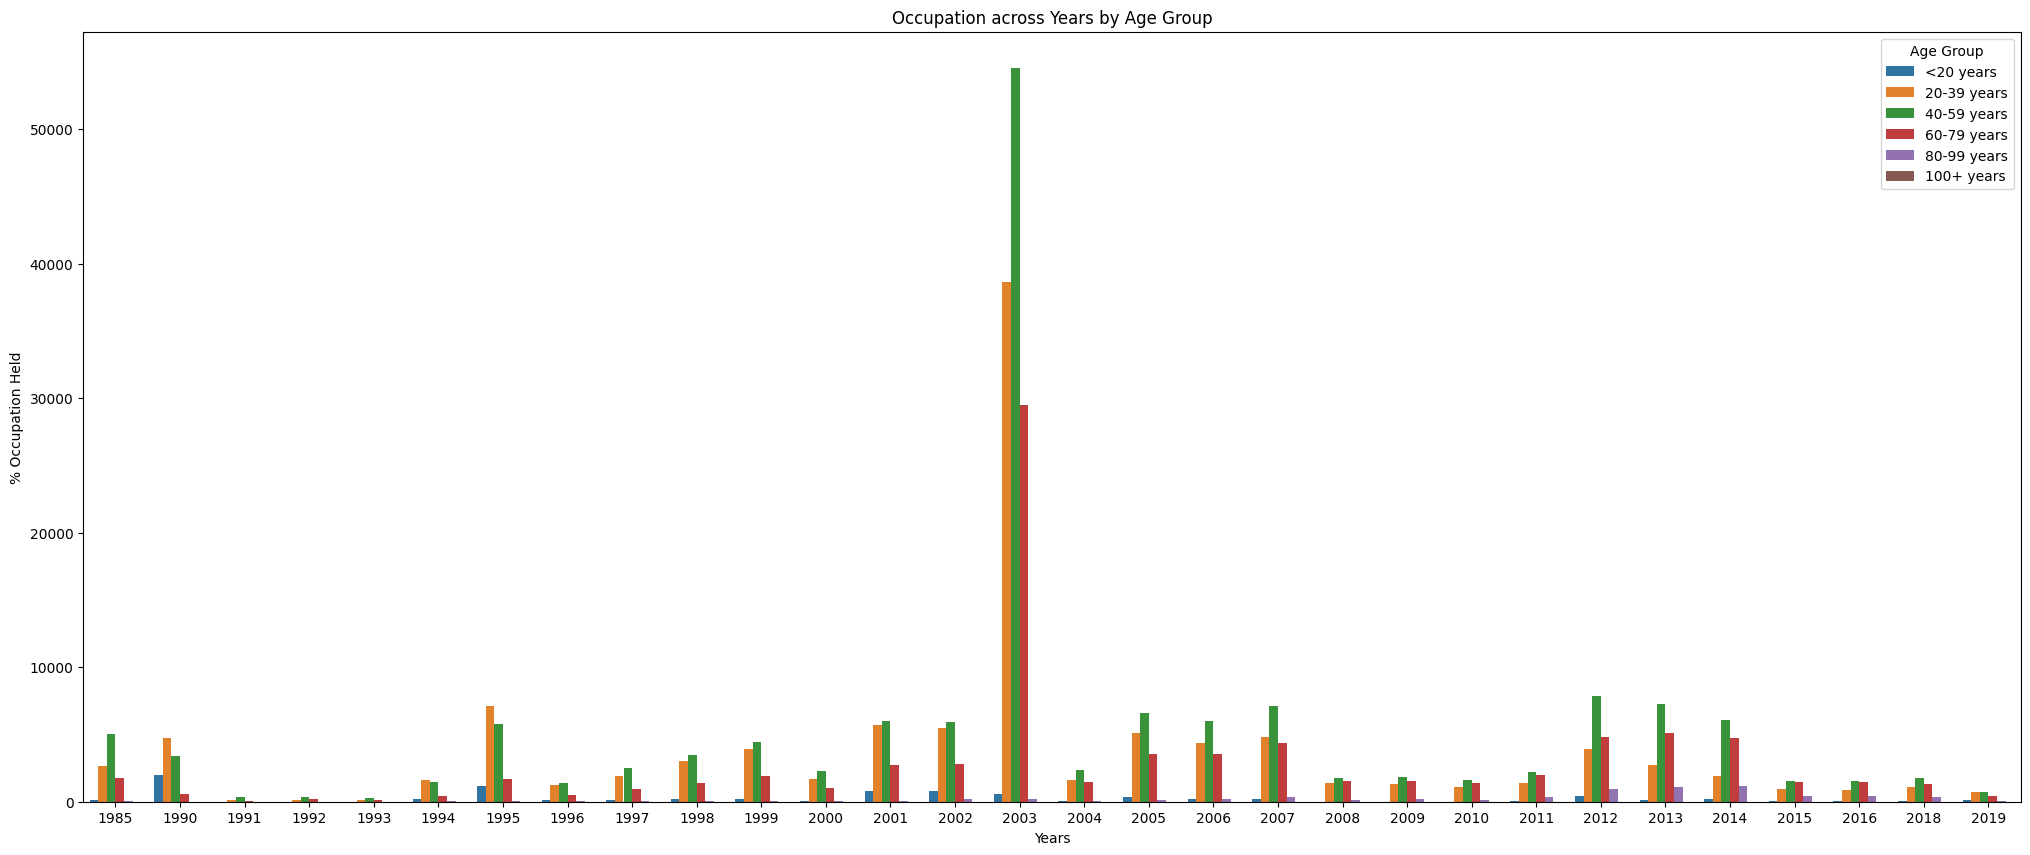

In [8]:
# plot those that have occupations by age group and years

df_occ_year = pd.DataFrame(df_2_3.groupby(['Year', 'Age Group'], as_index=False)["Occupation"].count())
df_occ_year['Occupation Held Percentage'] = (df_occ_year['Occupation'] / df_occ_year['Occupation'].sum()) * 100
display(df_occ_year)
ax = sns.barplot(data = df_occ_year, x = "Year", y = "Occupation", hue = "Age Group")
plt.rcParams["figure.figsize"] = (25, 10)
plt.title("Occupation across Years by Age Group")
plt.xlabel("Years")
plt.ylabel("% Occupation Held")
plt.show()

### 6.1 Clean and re-coding unaggrevated data  

As occupational data from the graph database are extracted directly from the raw datasets, specific occupation titles are repeated, such as 'agricultural worker' and 'Agricultural worker' etc. Given the raw data in the database is directly drawn from heterogeneous sources, it's reasonable to believe that duplicates (upon manual inspection) will exist despite the transformation process. Below re-code all occupations titles that are explicitly labelled `missing`, `not applicable`, `other` or something similiar to `NA` or other erroneous by removing them from the unaggregated dataset.

To reduce the complexity of the labels (and improve it's distribution), we have used unsupervised text classification to map occupational data (based on the current occupation titles which are explicitly labelled in the dataset) to the _International Standard Classification of Occupations (ISCO-08)_ codes. More information about this taxonomy can be access [here](https://isco-ilo.netlify.app/en/isco-08/).

In [9]:
# remove duplicates (upon manual inspection)

df_2_3.loc[df_2_3['Occupation'] == 'armed forces', 'Occupation'] = 'armed force'
df_2_3.loc[df_2_3['Occupation'] == 'directors and chief executives of enterprises', 'Occupation'] = 'directors and chief executives'
df_2_3.loc[df_2_3['Occupation'] == 'don t know', 'Occupation'] = 'dont know'
df_2_3.loc[df_2_3['Occupation'] == 'electrical engineering technicians', 'Occupation'] = 'electrical engineers'
df_2_3.loc[df_2_3['Occupation'] == 'employer  manager of establishment with less than    employees', 'Occupation'] = 'employer manager of establishment with less than X employees'
df_2_3.loc[df_2_3['Occupation'] == 'employer manager of establishment with less than    employes  less    emp', 'Occupation'] = 'employer manager of establishment with less than X employees'
df_2_3.loc[df_2_3['Occupation'] == 'employer manager of establishment with less than    employees', 'Occupation'] = 'employer manager of establishment with less than X employees'
df_2_3.loc[df_2_3['Occupation'] == 'missing not available', 'Occupation'] = 'missing'
df_2_3.loc[df_2_3['Occupation'] == 'modern health ass.profess.nec', 'Occupation'] = 'modern health assessment professional'
df_2_3.loc[df_2_3['Occupation'] == 'modern health ass.professionals', 'Occupation'] = 'modern health assessment professional'
df_2_3.loc[df_2_3['Occupation'] == 'never had job', 'Occupation'] = 'never had a job'
df_2_3.loc[df_2_3['Occupation'] == 'non manual   office worker   non sup', 'Occupation'] = 'non-manual office worker non-supervisor'
df_2_3.loc[df_2_3['Occupation'] == 'non manual   office worker  non supervisor', 'Occupation'] = 'non-manual office worker non-supervisor'
df_2_3.loc[df_2_3['Occupation'] == 'other  cs', 'Occupation'] = 'other'
df_2_3.loc[df_2_3['Occupation'] == 'power production rel.plant operators', 'Occupation'] = 'power production plant operators'
df_2_3.loc[df_2_3['Occupation'] == 'professional worker lawyer  accountant  teacher  etc', 'Occupation'] = 'professional worker lawyer'
df_2_3.loc[df_2_3['Occupation'] == 'professional worker lawyer  accounta', 'Occupation'] = 'professional worker lawyer'
df_2_3.loc[df_2_3['Occupation'] == 'supervisory   office worker   superv', 'Occupation'] = 'supervisory office worker'
df_2_3.loc[df_2_3['Occupation'] == 'supervisory   office worker  supervises others', 'Occupation'] = 'supervisory office worker'
df_2_3.loc[df_2_3['Occupation'] == 'unskilled manual', 'Occupation'] = 'unskilled manual worker'
df_2_3.loc[df_2_3['Occupation'] == 'company officer', 'Occupation'] = 'officer company'
df_2_3.loc[df_2_3['Occupation'] == 'worker agricultural', 'Occupation'] = 'agricultural worker'
df_2_3.loc[df_2_3['Occupation'] == 'company officer', 'Occupation'] = 'officer company'
df_2_3.loc[df_2_3['Occupation'] == 'officer field', 'Occupation'] = 'field officer'

# re-code 'other'
df_2_3['Occupation'] = df_2_3['Occupation'].replace(['jp kg tj  other other'], 'other')

# re-code 'missing', 'not applicable', etc.
df_2_3['Occupation'] = df_2_3['Occupation'].replace(['missing'], np.nan)
df_2_3['Occupation'] = df_2_3['Occupation'].replace(['skip not applicable missing'], np.nan)
df_2_3['Occupation'] = df_2_3['Occupation'].replace(['not applicable'], np.nan)
df_2_3['Occupation'] = df_2_3['Occupation'].replace(['dont know'], np.nan)
df_2_3['Occupation'] = df_2_3['Occupation'].replace(['no answer'], np.nan)
df_2_3['Occupation'] = df_2_3['Occupation'].replace(['don t want to answer'], np.nan)
df_2_3['Occupation'] = df_2_3['Occupation'].replace(['don t know'], np.nan)
df_2_3['Occupation'] = df_2_3['Occupation'].replace(['missing  not available'], np.nan)

# re-code 'never work', etc.
df_2_3['Occupation'] = df_2_3['Occupation'].replace(['never job'], np.nan)
df_2_3['Occupation'] = df_2_3['Occupation'].replace(['never worked'], np.nan)

# recode 'missing', 'not applicable', etc. for DOB
df_2_3['DOB'] = df_2_3['DOB'].replace(['NaN'], np.nan)
df_2_3['DOB'] = df_2_3['DOB'].replace(['NA'], np.nan)

df_2_3 = df_2_3.dropna()

# output to notes and csv file
display(df_2_3)
df_2_3.to_csv("occupation_age_data.csv")

,Year,Person,DOB,Occupation,Age,Age Group
5,1997,10241,1957-8-01,doctors dentists veterinarians and related m...,39,20-39 years
6,2002,10241,1957-8-01,doctors dentists veterinarians and related m...,44,40-59 years
7,2001,10241,1957-8-01,doctors dentists veterinarians and related m...,43,40-59 years
9,1997,90614,1945-1-01,building caretaker cleaners n.e.c.,52,40-59 years
12,1996,90614,1945-1-01,building caretaker cleaners n.e.c.,50,40-59 years
...,...,...,...,...,...,...
469992,2015,433206,1967-12-01,secretaries keyboard operating clerks,47,40-59 years
469993,1995,71469,1944-7-01,armed forces officer sergeants,50,40-59 years
469994,2019,446070923,1987-06-01,skilled worker for example foreman motor me...,31,20-39 years
469995,2014,360202,1937-6-01,nursing midwifery professionals,76,60-79 years


### 6.2 Transforming occupation title by including ISCO-08 occupation groups

Unsupervised text classification has been used somewhere else to classify occupation titles, detail notes of modelling and evaluation results are found [here](https://github.com/tsa-ml/tsa-ml/blob/main/Use%20Cases%20-%20Occupation.ipynb). This includes using Title2Vec embeddings by [Junhua Liu et al.](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-022-00649-5) and Nearest Neighbour, Fasttext embeddings using Gaussian Mixture clustering, and Bidirectional Encoder Representations from Transformers. 

The next section of these notes begin with cleaning the dataset, and then applying a pre-trained BERT model which classify's occupation titles into the International Standard Classification of Occupations (ISCO-08) occupation groups as mentioned previously in these notes. 

[nltk_data] Downloading package stopwords to /Users/b/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/b/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


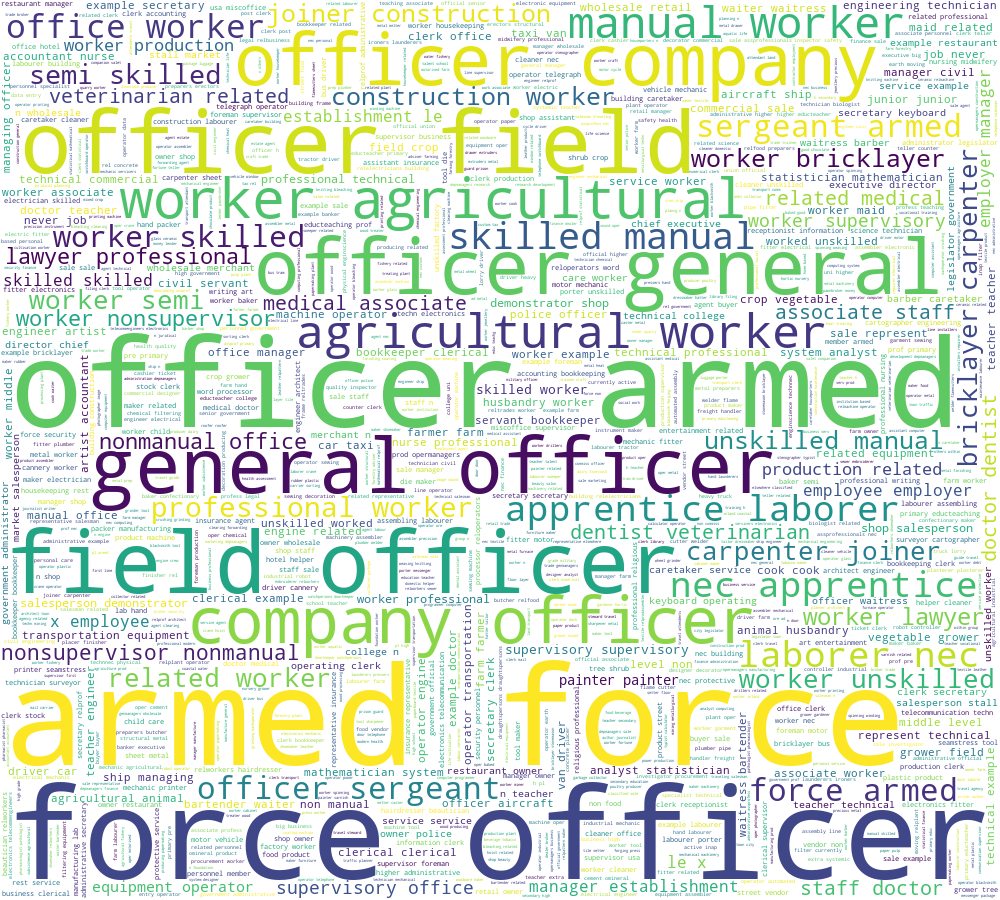

In [3]:
## clean occupation data
nltk.download("stopwords")
nltk.download("wordnet")

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())    
    ## Tokenize (convert from string to list)
    lst_text = text.split()    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]          
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]              
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]            
    ## back to string from list
    text = " ".join(lst_text)
    return text

df_m3 = pd.read_csv('model3_ISCO_08_data.csv')                         # data contain model 3: BERT (Title2Vec)
df_m3.rename(columns = {'job titles':'Occupation'}, inplace = True)      
df_2_3 = pd.read_csv('occupation_age_data.csv')                        # unaggrevated data for analysis
df_2_3["Occupation"] = df_2_3["Occupation"].apply(lambda x: 
    utils_preprocess_text(x, 
                          flg_stemm=False, 
                          flg_lemm=True, 
                          lst_stopwords=nltk.corpus.stopwords.words("english"))
)
df_2_3 = pd.merge(df_2_3, df_m3, on ='Occupation', how ='inner')
df_2_3.rename(columns = {'predicted ISCO-08 categories':'ISCO08'}, inplace = True)
df_2_3 = df_2_3.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)

## explore occupation data using word cloud (include removing nan)
long_string = ','.join(list(df_2_3["Occupation"].values))
long_string = long_string.replace(',nan', '')
long_string = long_string.replace(',nan,', ',')
wordcloud = WordCloud(background_color = "white", 
                      max_words = 1000000, 
                      contour_width = 100, 
                      contour_color = 'steelblue',
                      width = 1000,
                      height = 900)
wordcloud.generate(long_string)
wordcloud.to_image()


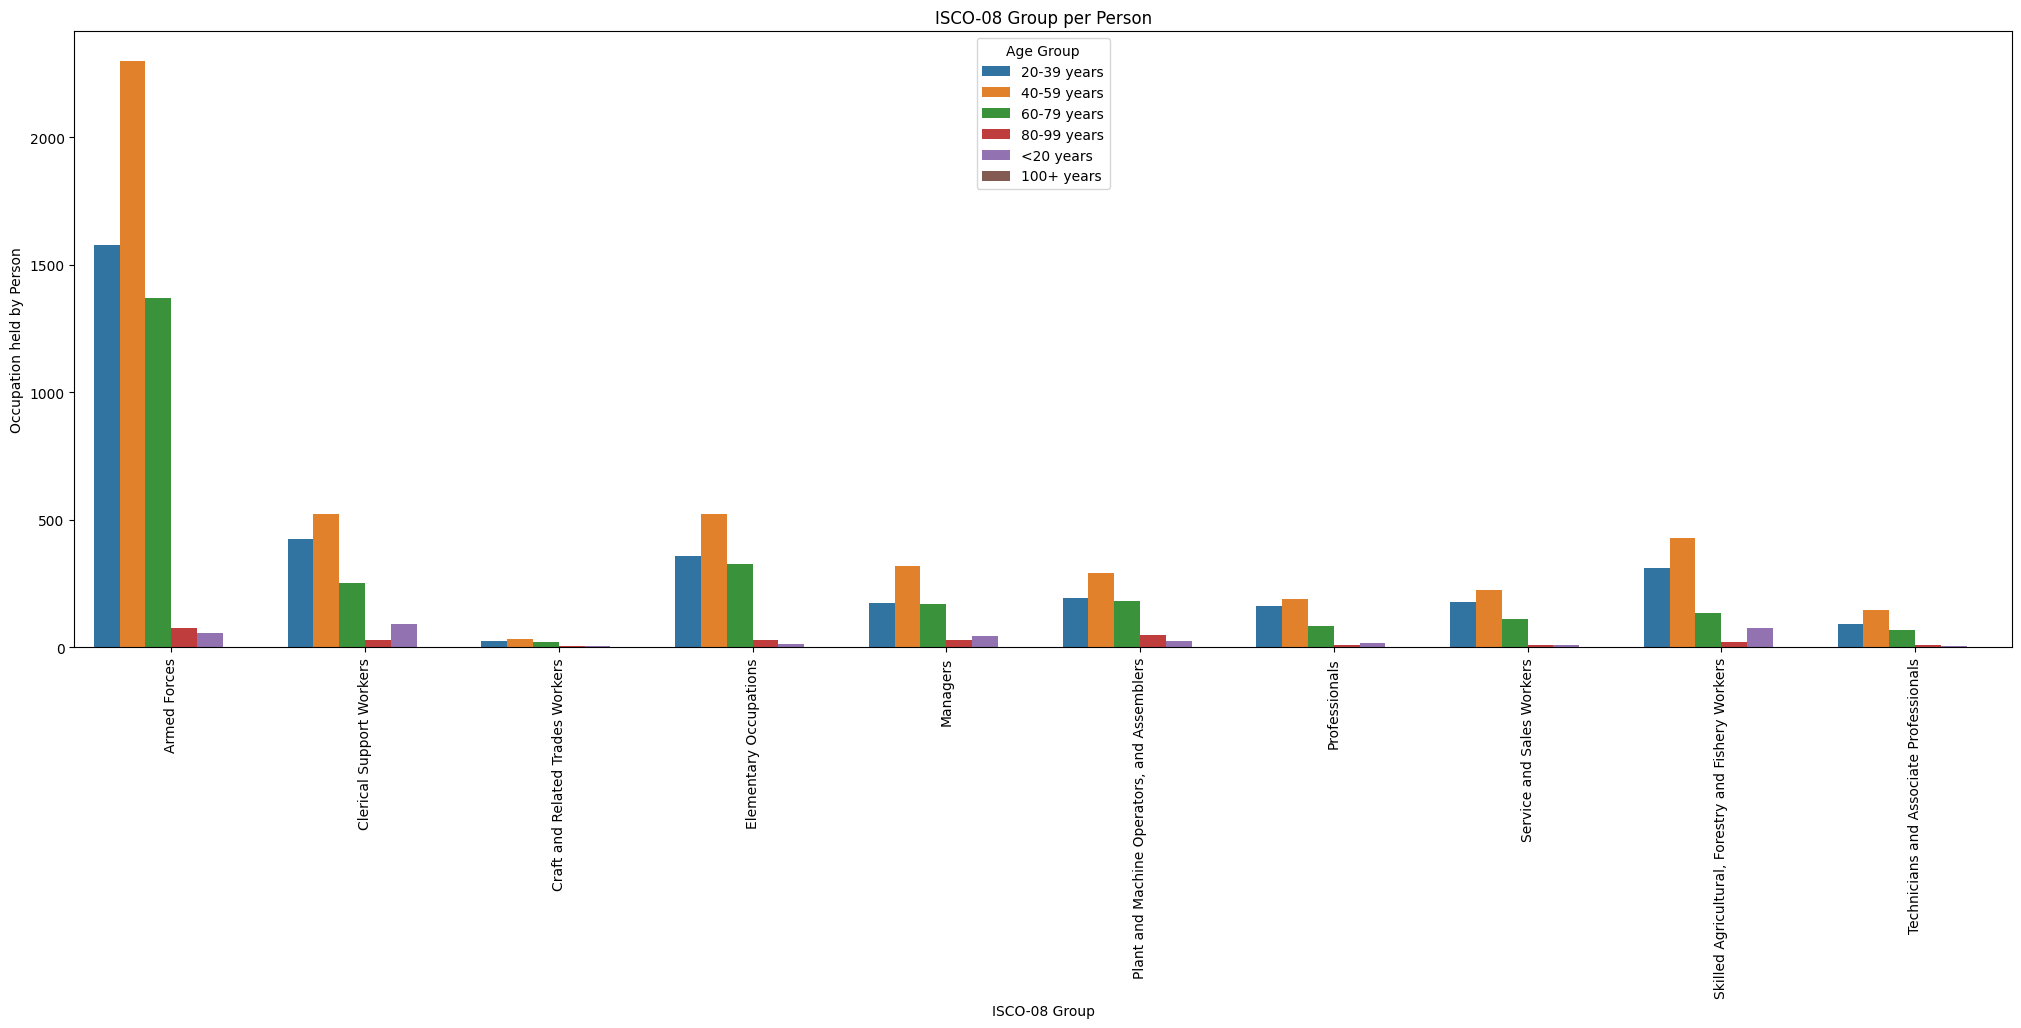

In [5]:
df_occ = pd.DataFrame(df_2_3.groupby(['Year', 'Age Group', 'ISCO08'], as_index=False)["Occupation"].count())
ax = sns.barplot(data = df_occ, x = "ISCO08", y = "Occupation", hue = "Age Group", errorbar = None)
plt.rcParams["figure.figsize"] = (25, 8)
plt.xticks(rotation = 90)
plt.title("ISCO-08 Group per Person")
plt.xlabel("ISCO-08 Group")
plt.ylabel("Occupation held by Person")
plt.show()


### 6.3 Describe the means, variance and covariance for age and occupation

In [6]:
bins = [0, 20, 40, 60, 80, 100, 150]
groups = ["<20 years", "20-39 years", "40-59 years", "60-79 years", "80-99 years", "100+ years"]
df_2_3["Age Group"] = pd.cut(df_2_3["Age"], bins = bins, labels = groups)
display("Age by ISCO-08 Occupation Group")
df2_cross = pd.crosstab(columns = df_2_3["Age Group"], index = df_2_3["ISCO08"], 
                        margins = True, margins_name = "total")
display(df2_cross)


'Age by ISCO-08 Occupation Group'

Age Group,<20 years,20-39 years,40-59 years,60-79 years,80-99 years,100+ years,total
ISCO08,,,,,,,
Armed Forces,1135,47302,69003,38378,1468,3,157289
Clerical Support Workers,2233,12768,15755,7612,796,0,39164
Craft and Related Trades Workers,27,650,870,512,39,0,2098
Elementary Occupations,259,10733,15695,9787,766,0,37240
Managers,934,5074,9268,4999,760,10,21045
"Plant and Machine Operators, and Assemblers",640,5860,8720,5520,854,0,21594
Professionals,399,4825,5662,2515,204,0,13605
Service and Sales Workers,129,5305,6809,3342,239,0,15824
"Skilled Agricultural, Forestry and Fishery Workers",1620,8418,11994,3839,429,3,26303


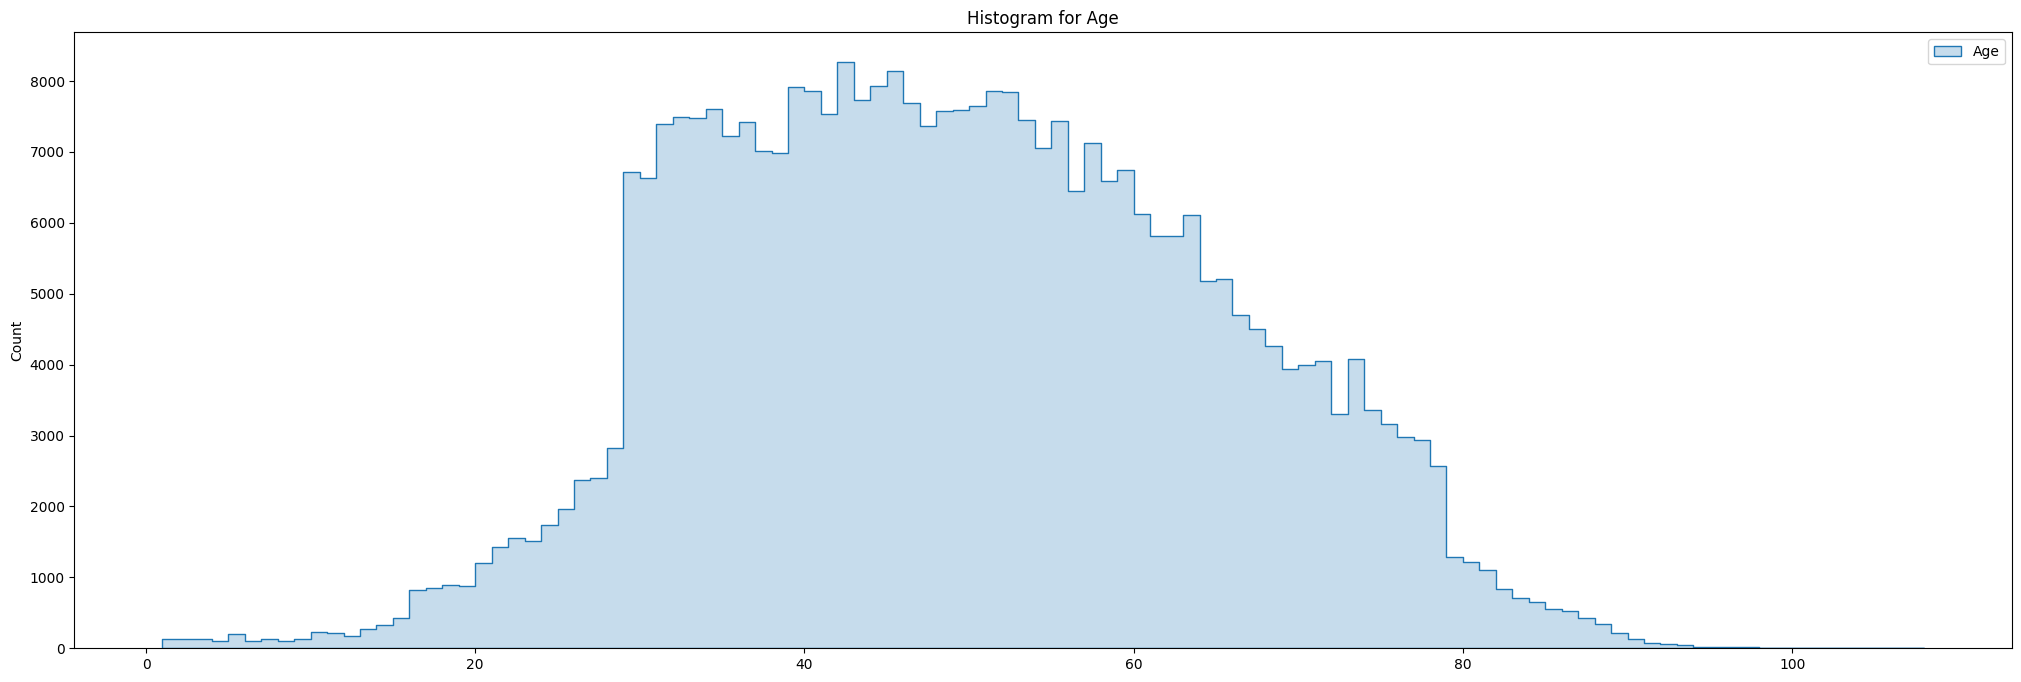

In [7]:
sns.histplot([df_2_3["Age"], df_2_3["ISCO08"]],
             kde = False, 
             common_norm = False,
             legend = True,
             element = "step", 
             binwidth = 1.0)
plt.rcParams["figure.figsize"] = (15, 4)
plt.title("Histogram for Age")
plt.show()


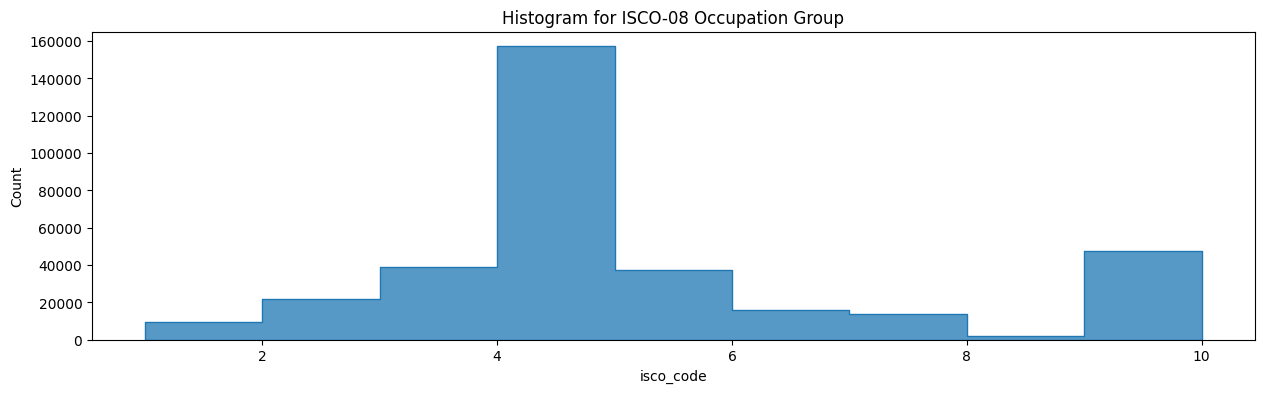

In [8]:
isco_mapping = {"Technicians and Associate Professionals": 1, 
                "Plant and Machine Operators, and Assemblers": 2,
                "Clerical Support Workers": 3, 
                "Armed Forces": 4,
                "Elementary Occupations": 5, 
                "Service and Sales Workers": 6,
                "Professionals": 7, 
                "Craft and Related Trades Workers": 8,
                "Managers": 9, 
                "Skilled Agricultural, Forestry and Fishery Workers": 10}
df_2_3["isco_code"] = df_2_3.ISCO08.map(isco_mapping)

sns.histplot(df_2_3["isco_code"],
             kde = False, 
             common_norm = False,
             legend = False,
             element = "step", 
             binwidth = 1.0)
plt.rcParams["figure.figsize"] = (15, 4)
plt.title("Histogram for ISCO-08 Occupation Group")
plt.show()


In [14]:
# descriptive statistics for age
display("----------------------------------------------------------------------------------------------------")
display("Summary Statistics for Age")
total_mean_age = df_2_3.loc[:, "Age"].mean()
total_sd_age = df_2_3.loc[:, "Age"].std()
total_var_age = df_2_3.loc[:, "Age"].var()
print("Mean: " + str(total_mean_age))
print("Standard Deviation: " + str(total_sd_age))
print("Variability： " + str(total_var_age))
print(" ")

# descriptive statistics for ISCO-08 occupation group
display("Summary Statistics for ISCO-08 Occupation Group")
total_mean_isco = df_2_3.loc[:, "isco_code"].mean()
total_sd_isco = df_2_3.loc[:, "isco_code"].std()
total_var_isco = df_2_3.loc[:, "isco_code"].var()
print("Mean: " + str(total_mean_isco))
print("Standard Deviation: " + str(total_sd_isco))
print("Variability： " + str(total_var_isco))
print(" ")

# descriptve statistics for Age within and between ISCO-08 occupation groups 
within_numtotal = 0
between_numtotal = 0
denomtotal = 0
display("----------------------------------------------------------------------------------------------------")
display("Summary Statistics for Age group by ISCO-08 Occupation Groups")
for key in isco_mapping.keys():
    df_group = df_2_3.loc[df_2_3["ISCO08"] == key]
    group_len = len(df_group)
    group_mean = df_group.loc[:, "Age"].mean()
    group_sd = np.std(df_group.loc[:, "Age"])
    group_size = len(df_group.loc[:, "Age"])
    # print stats
    display("-::" + key + "::-")
    print("Mean Age: " + str(group_mean))
    print("Standard Deviation of Age: " + str(group_sd))
    print("Size of Age: " + str(group_size))
    # within-group variance (population variance)
    within_numi = (group_len)*group_sd**2
    within_numtotal = within_numtotal + within_numi
    # between-group variance (sample variance)
    between_numi = group_len * ((group_mean - total_mean_age)**2)
    between_numtotal = between_numtotal + between_numi
    # denominator (n - 1)
    denomi = group_len
    denomtotal = denomtotal + denomi
    print(" ")
within_variance = within_numtotal / (denomtotal - group_len)
between_variance = between_numtotal / (group_len - 1)
display("Within-group (Population) Variance for Age based on ISCO groups: " + str(within_variance))
display("Between-group (Sample) Variance for Age based on ISCO groups: " + str(between_variance))
display("----------------------------------------------------------------------------------------------------")


'----------------------------------------------------------------------------------------------------'

'Summary Statistics for Age'

Mean: 49.054203588141256
Standard Deviation: 15.457743847167556
Variability： 238.94184484464643
 


'Summary Statistics for ISCO-08 Occupation Group'

Mean: 4.7892775087432184
Standard Deviation: 2.2408651723222617
Variability： 5.02147672052688
 


'----------------------------------------------------------------------------------------------------'

'Summary Statistics for Age group by ISCO-08 Occupation Groups'

'-::Technicians and Associate Professionals::-'

Mean Age: 49.644317075808374
Standard Deviation of Age: 14.49279889227948
Size of Age: 9247
 


'-::Plant and Machine Operators, and Assemblers::-'

Mean Age: 50.66703713994628
Standard Deviation of Age: 16.85301674016389
Size of Age: 21594
 


'-::Clerical Support Workers::-'

Mean Age: 46.35149627208661
Standard Deviation of Age: 16.78199211896838
Size of Age: 39164
 


'-::Armed Forces::-'

Mean Age: 49.80348276103224
Standard Deviation of Age: 14.677552561438823
Size of Age: 157289
 


'-::Elementary Occupations::-'

Mean Age: 50.82209989258862
Standard Deviation of Age: 15.163392597795404
Size of Age: 37240
 


'-::Service and Sales Workers::-'

Mean Age: 48.44438827098079
Standard Deviation of Age: 14.58697690414732
Size of Age: 15824
 


'-::Professionals::-'

Mean Age: 46.56119073869901
Standard Deviation of Age: 15.602189625518065
Size of Age: 13605
 


'-::Craft and Related Trades Workers::-'

Mean Age: 49.66062917063871
Standard Deviation of Age: 15.588401740169342
Size of Age: 2098
 


'-::Managers::-'

Mean Age: 50.08952245188881
Standard Deviation of Age: 16.79815936994689
Size of Age: 21045
 


'-::Skilled Agricultural, Forestry and Fishery Workers::-'

Mean Age: 45.342888643880926
Standard Deviation of Age: 15.535609068223378
Size of Age: 26303
 


'Within-group (Population) Variance for Age based on ISCO groups: 255.52436752230608'

'Between-group (Sample) Variance for Age based on ISCO groups: 39.017221765719746'

'----------------------------------------------------------------------------------------------------'

## <font color=purple>8. Relatoinship between Age and Occupation</font>

Bivariate analysis was conducted to examine the association between people's age and occupation. The strength of the relationship between individual's age and occupation using statisical (p-value) test.

'Contigency Table: Count'

,40+ years,<40 years
index,,
Non-professionals,217470,103087
Professionals,14910,7942


'Contigency Table: Pearson’s chi-square statistic'

65.67508802635513

5.551115123125783e-16

,40+ years,<40 years
index,,
Non-professionals,1.412986,2.957333
Professionals,19.820701,41.484067


'2x2 Table: OR - odds ratio'

,Estimate,SE,LCB,UCB,p-value
Odds ratio,1.124,,1.092,1.156,0.000
Log odds ratio,0.117,0.014,0.088,0.145,0.000
Risk ratio,1.040,,1.030,1.050,0.000
Log risk ratio,0.039,0.005,0.029,0.049,0.000


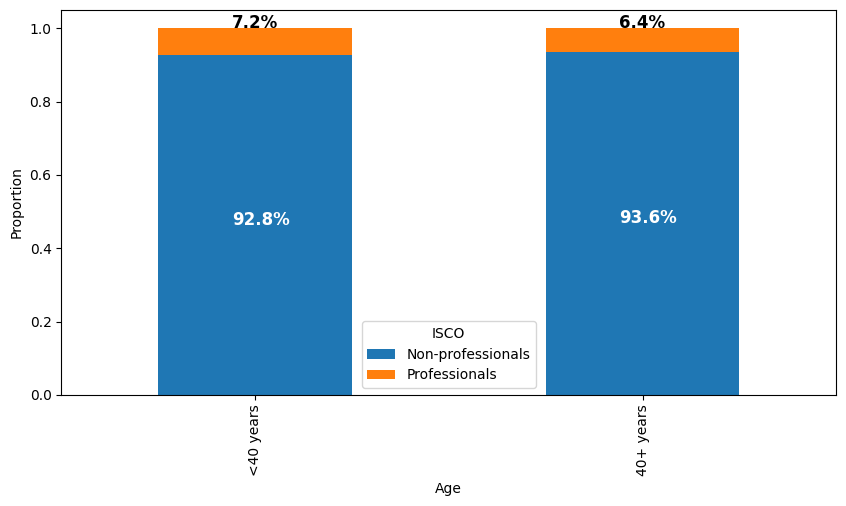

In [22]:
df_2_3_copy = df_2_3.copy()

# test association between old vs younger groups, professions vs non-professional
bins = [0, 40, 150]
groups = ["<40 years", "40+ years"]
df_2_3_copy["OldVsYoung"] = pd.cut(df_2_3["Age"], bins = bins, labels = groups)
df_isco_copy = pd.DataFrame(df_2_3_copy["ISCO08"].copy())
df_isco_copy.loc[(df_isco_copy['ISCO08'] == 'Technicians and Associate Professionals'), 'ISCO08'] = 'Professionals'
df_isco_copy.loc[(df_isco_copy['ISCO08'] != 'Professionals'), 'ISCO08'] = 'Non-professionals'
df_2_3_copy["ProfVsNonProf"] = df_isco_copy

# cross tables
df_cross_stack1 = pd.crosstab(columns = df_2_3_copy["ProfVsNonProf"], 
                              index = df_2_3_copy["OldVsYoung"],
                              normalize = "index")
df_cross_stack2 = df_cross_stack1.copy()
df_cross_stack2.loc["<40 years"]["Non-professionals"] = np.round((df_cross_stack1.loc["<40 years"]["Non-professionals"]) * 100, 1)
df_cross_stack2.loc["40+ years"]["Non-professionals"] = np.round((df_cross_stack1.loc["40+ years"]["Non-professionals"]) * 100, 1)
df_cross_stack2.loc["<40 years"]["Professionals"] = np.round((df_cross_stack1.loc["<40 years"]["Professionals"]) * 100, 1)
df_cross_stack2.loc["40+ years"]["Professionals"] = np.round((df_cross_stack1.loc["40+ years"]["Professionals"]) * 100, 1)

# contigency table
data1 = pd.DataFrame(list(df_2_3_copy["OldVsYoung"]), list(df_2_3_copy["ProfVsNonProf"])).reset_index()
table1 = sm.stats.Table.from_data(data1)
display("Contigency Table: Count")
display(table1.table_orig)
display("Contigency Table: Pearson’s chi-square statistic")
results = table1.test_nominal_association()
display(results.statistic)
display(results.pvalue)
display(table1.chi2_contribs)
display("2x2 Table: OR - odds ratio")
results_odds = sm.stats.Table2x2(table1.table_orig.values)
display(results_odds.summary())

# plot
ax = df_cross_stack1.plot(kind='bar', stacked=True)
plt.rcParams["figure.figsize"] = (10, 5)
plt.xlabel("Age")
plt.ylabel("Proportion")
plt.legend(title = "ISCO")
c1 = "white"
c2 = "black"
fs = 12
fw = "bold"

ax.text(x = 0 - 0.06, 
        y = df_cross_stack1.loc["<40 years"]["Non-professionals"] - (df_cross_stack1.loc["<40 years"]["Non-professionals"] / 2), 
        s = f'{df_cross_stack2.loc["<40 years"]["Non-professionals"]}%', 
        color = c1,
        fontsize = fs,
        fontweight = fw)

ax.text(x = 1 - (0.06), 
        y = df_cross_stack1.loc["40+ years"]["Non-professionals"] - (df_cross_stack1.loc["40+ years"]["Non-professionals"] / 2), 
        s = f'{df_cross_stack2.loc["40+ years"]["Non-professionals"]}%', 
        color = c1,
        fontsize = fs,
        fontweight = fw)

ax.text(x = 0 - 0.06, 
        y = df_cross_stack1.loc["<40 years"]["Professionals"] + df_cross_stack1.loc["<40 years"]["Non-professionals"], 
        s = f'{df_cross_stack2.loc["<40 years"]["Professionals"]}%', 
        color = c2,
        fontsize = fs,
        fontweight = fw)

ax.text(x = 1 - 0.06, 
        y = df_cross_stack1.loc["40+ years"]["Professionals"] + df_cross_stack1.loc["40+ years"]["Non-professionals"], 
        s = f'{df_cross_stack2.loc["40+ years"]["Professionals"]}%', 
        color = c2,
        fontsize = fs,
        fontweight = fw)

plt.show()

## 8.1 Regression on a person's age and occupation

In [17]:
# regression on young and old VS professional and non-professional
encoder = OrdinalEncoder()
age_g = encoder.fit_transform(np.array(df_2_3_copy.loc[:, "OldVsYoung"]).reshape(len(df_2_3_copy), 1))
occ_g = encoder.fit_transform(np.array(df_2_3_copy.loc[:, "ProfVsNonProf"]).reshape(len(df_2_3_copy), 1))
mod_prob = OrderedModel(pd.DataFrame(age_g), pd.DataFrame(occ_g), distr='logit')
res_prob = mod_prob.fit(method='bfgs')

display("Parameters: ", res_prob.params)

res_prob.summary()

Optimization terminated successfully.
         Current function value: 0.629248
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8


'Parameters: '

0          0.116619
0.0/1.0    0.746486
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      0   Log-Likelihood:            -2.1609e+05
Model:                   OrderedModel   AIC:                         4.322e+05
Method:            Maximum Likelihood   BIC:                         4.322e+05
Date:                Sun, 30 Jul 2023                                         
Time:                        18:58:35                                         
No. Observations:              343409                                         
Df Residuals:                  343407                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1166      0.014      8.100      0.000       0.088       0.145
0.0/1.0        0.7465      0.004    197.411      0.000       0.739       0.754
==============================================================================
"""

In [18]:
logit_mod = sm.Logit(pd.DataFrame(age_g), sm.add_constant(pd.DataFrame(occ_g)))
logit_res = logit_mod.fit()

display("Parameters: ", res_prob.params)

logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.629248
         Iterations 4


'Parameters: '

0          0.116619
0.0/1.0    0.746486
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      0   No. Observations:               343409
Model:                          Logit   Df Residuals:                   343407
Method:                           MLE   Df Model:                            1
Date:                Sun, 30 Jul 2023   Pseudo R-squ.:               0.0001502
Time:                        18:58:42   Log-Likelihood:            -2.1609e+05
converged:                       True   LL-Null:                   -2.1612e+05
Covariance Type:            nonrobust   LLR p-value:                 7.796e-16
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7465      0.004   -197.411      0.000      -0.754      -0.739
0              0.1166      0.014      8.100      0.000       0.088       0.145
==============================================================================
"""

In [97]:
# encode isco and age groups (categorical variable) for regression
isco = np.array(df_2_3_copy.loc[:, "ISCO08"]).reshape(len(df_2_3_copy), 1)
df_2_3_copy.loc[:, "isco_code"] = list(encoder.fit_transform(isco).reshape(1, -1)[0])
display(encoder.categories_)
age_groups = np.array(df_2_3_copy.loc[:, "Age Group"]).reshape(len(df_2_3_copy), 1)
df_2_3_copy.loc[:, "Age Group"] = list(encoder.fit_transform(age_groups).reshape(1, -1)[0])

# develop dataframe for regression
df_test = pd.DataFrame({"age":df_2_3_copy["Age"], 
                        "isco":df_2_3_copy["isco_code"], 
                        "age_group":df_2_3_copy["Age Group"]})

display(df_test.describe())

[array(['Armed Forces', 'Clerical Support Workers',
        'Craft and Related Trades Workers', 'Elementary Occupations',
        'Managers', 'Plant and Machine Operators, and Assemblers',
        'Professionals', 'Service and Sales Workers',
        'Skilled Agricultural, Forestry and Fishery Workers',
        'Technicians and Associate Professionals'], dtype=object)]

,age,isco,age_group
count,343409.000000,343409.00000,343409.000000
mean,49.054204,2.42648,2.025556
std,15.457744,2.92343,0.890112
min,1.000000,0.00000,0.000000
25%,37.000000,0.00000,1.000000
50%,48.000000,1.00000,2.000000
75%,60.000000,5.00000,3.000000
max,108.000000,9.00000,5.000000


In [20]:
mlogit_mod = sm.MNLogit(df_test["age_group"], sm.add_constant(df_test["isco"]))
mlogit_res = mlogit_mod.fit()
display(mlogit_res.params)
display(mlogit_res.summary())

Optimization terminated successfully.
         Current function value: 1.210691
         Iterations 13


,0,1,2,3,4
const,9.278492,9.635800,9.069794,6.150732,6.279837
isco,-0.157599,-0.157277,-0.187300,-0.073769,-0.035117


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              age_group   No. Observations:               343409
Model:                        MNLogit   Df Residuals:                   343399
Method:                           MLE   Df Model:                            5
Date:                Sun, 30 Jul 2023   Pseudo R-squ.:                0.002479
Time:                        19:03:37   Log-Likelihood:            -4.1576e+05
converged:                       True   LL-Null:                   -4.1680e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================
age_group=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.2785      0.395     23.477      0.000       8.504      10.053
isco           -0.1576      0.077     -2.059      0.039      -0.308      -0.008
-------------------------------------------------------------------------------
age_group=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.6358      0.395     24.382      0.000       8.861      10.410
isco           -0.1573      0.077     -2.055      0.040      -0.307      -0.007
-------------------------------------------------------------------------------
age_group=3       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.0698      0.395     22.949      0.000       8.295       9.844
isco           -0.1873      0.077     -2.448      0.014      -0.337      -0.037
-------------------------------------------------------------------------------
age_group=4       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.1507      0.396     15.546      0.000       5.375       6.926
isco           -0.0738      0.077     -0.963      0.336      -0.224       0.076
-------------------------------------------------------------------------------
age_group=5       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.2798      0.396     15.875      0.000       5.505       7.055
isco           -0.0351      0.077     -0.458      0.647      -0.185       0.115
===============================================================================
"""

In [21]:
mlogit_mod = sm.MNLogit(df_test["isco"], sm.add_constant(df_test["age"]))
mlogit_res = mlogit_mod.fit()
display(mlogit_res.summary())

Optimization terminated successfully.
         Current function value: 1.779885
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                   isco   No. Observations:               343409
Model:                        MNLogit   Df Residuals:                   343391
Method:                           MLE   Df Model:                            9
Date:                Sun, 30 Jul 2023   Pseudo R-squ.:                0.003541
Time:                        19:23:02   Log-Likelihood:            -6.1123e+05
converged:                       True   LL-Null:                   -6.1340e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
    isco=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6821      0.018    -37.030      0.000      -0.718      -0.646
age           -0.0147      0.000    -39.543      0.000      -0.015      -0.014
------------------------------------------------------------------------------
    isco=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.2872      0.074    -57.841      0.000      -4.433      -4.142
age           -0.0006      0.001     -0.421      0.673      -0.003       0.002
------------------------------------------------------------------------------
    isco=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6554      0.020    -83.875      0.000      -1.694      -1.617
age            0.0043      0.000     11.447      0.000       0.004       0.005
------------------------------------------------------------------------------
    isco=4       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0714      0.025    -83.171      0.000      -2.120      -2.023
age            0.0012      0.000      2.526      0.012       0.000       0.002
------------------------------------------------------------------------------
    isco=5       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1675      0.025    -87.313      0.000      -2.216      -2.119
age            0.0036      0.000      7.710      0.000       0.003       0.005
------------------------------------------------------------------------------
    isco=6       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7817      0.029    -61.482      0.000      -1.839      -1.725
age           -0.0138      0.001    -23.480      0.000      -0.015      -0.013
------------------------------------------------------------------------------
    isco=7       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0145      0.028    -72.774      0.000      -2.069      -1.960
age           -0.0057      0.001    -10.564      0.000      -0.007      -0.005
------------------------------------------------------------------------------
    isco=8       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8774      0.021    -40.920      0.000      -0.919      -0.835
age           -0.0192      0.000    -43.230      0.000      -0.020      -0.018
------------------------------------------------------------------------------
  

## <font color=purple>9. Interpretation of Results</font>

This section provides an interpretion of the results, including a summary of other findings from the modelling done on age and occupation in the dataset. Below provides a brief summary of the note findings.

- There was a lower proportion of older people ($40+$ years) that worked in professional occupations ($6.4\%$) compare to the younger people ($<40$ years) and work in professional occupations ($7.2\%$). Although, these observed difference were comparatively small. The Pearson's $X^{2}$ test found no statistical difference in the association of a person's young or old age, and those whom work either in a professional or non-professional occupation ($p = 5.54$). 
- Other association measures suggest groups are independent. Odds ratio measure found statistical difference in the association between a person's young or old age, and thier professional and non-professional occupation status ($OR = 1.24;$ $95\%$ $CI = 1.092$ $to$ $1.156, p < 0.05$).
- Ordinal Logisitic Regression was conducted to examine the causual relationship of people's occupation and age group. Assumptions were held for age groups, and ISCO groups. While there was a negative association with the number of occupations in each of the age groups, these factors were not significantly associated (alpha = 0.001). 
- Multiordinal Logisitic Regression found age were positively associated with Craft and Related Trades Workers and Managers. While Armed Forces, Plant and Machine Operators,and Assemblers, Professionals, Service and Sales Workers were negatively assoicated with a person's age. This relationship suggest less older individuals  will hold professional occupations, compare to those who are yonger, within the sample; however a person's age is generally not influenced by their occupation within the wider population of Taiwan, China, Hong Kong, and Macau.